# Práctica 4: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2025__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [ ]:
RANDOM_STATE = 1234

# 1) Carga del conjunto de datos

Los ficheros `fake.csv` y `true.csv` contienen artícuos de noticias clasificadas como fake (falsas) o true (reales) respectivamente. Cada noticia tiene como atributos:

*   Title: título de la noticia
*   Text: cuerpo del texto de la noticia
*   Subject: tema de la noticia
*   Date: fecha de publicación de la noticia

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 60% para entrenamiento, 20% para validación y el 20% restante para test. Comprueba que la distribución de los ejemplos en las particiones es similar.

In [ ]:
pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/MyDrive/pr3IA/jupyter'


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

%matplotlib inline

En primer lugar vamos a cargar los datos en un nuevo dataframe, que contendrá las noticias y la etiqueta de clasificación como noticia falsa o noticia real.

In [ ]:
# Cargar los datos
fake_df = pd.read_csv(f"{filepath}/Fake.csv")
true_df = pd.read_csv(f"{filepath}/True.csv")


# Añadir etiqueta
fake_df['label'] = 'fake'
true_df['label'] = 'true'

# Unir los datasets
df = pd.concat([fake_df, true_df])

df

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",true
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",true
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",true
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",true


Como podemos observar, el dataset consiste en noticias clasificadas según su contenido, su fecha de publicación y una etiqueta que las clasifica en función de si es una noticia falsa, o si es una noticia verdadera.

Ahora procedemos a mostrar un ejemplo de cada una de las clases en las que se clasifican las noticias, con el fin de posteriormente poder realizar un mejor estudio de los resultados de la clasificación de las noticias en función de las clases a las que pertenecen.

In [ ]:
print("Ejemplo noticia FAKE:\n")
print(fake_df.iloc[0]['text'])

print("\nEjemplo noticia TRUE:\n")
print(true_df.iloc[0]['text'])

Ejemplo noticia FAKE:

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His la

Como podemos observar, hemos impreso un ejemplo del dataset de noticias etiquetadas como verdaderas y otro ejemplo del dataset de noticias falsas. Esto nos puede servir de ayuda posteriormente a la hora de interpretar los datos que tenemos en el dataset.

Procedemos ahora a hacer un estudio del conjunto de datos que tenemos a nuestro alcance. Para ello vamos a usar la función Counter() que actúa como contador de palabras, y de todo ello vamos a seleccionar las 20 palabras más comunes en los textos de entrenamiento:

In [ ]:
from collections import Counter
# Dividir el texto en palabras sin limpiar nada
todas_palabras = df['text'].dropna().apply(lambda x: x.split())
frecuencia_total = Counter()

for lista in todas_palabras:
    frecuencia_total.update(lista)

# Mostrar las 20 palabras más comunes
print("Palabras más frecuentes:")
print(frecuencia_total.most_common(20))

Palabras más frecuentes:
[('the', 905825), ('to', 529815), ('of', 437532), ('and', 392470), ('a', 390084), ('in', 322378), ('that', 220928), ('on', 181758), ('s', 172259), ('for', 166256), ('is', 160009), ('was', 114171), ('with', 113690), ('he', 105668), ('Trump', 101305), ('as', 96723), ('The', 95236), ('said', 93137), ('by', 92699), ('his', 92058)]


Como podemos observar, en el corpus de documentos las palabras que más veces se repiten son aquellas como proposiciones o determinantes, que no aportan ningún tipo de información relevante con respecto al documento en el que aparecen.
Por ello, conviene hacer una normalización al corpus de documentos, pasando todas las palabras a minúsculas, eliminando stopwords, es decir palabras muy poco relevantes y que aportan muy poca información con respecto al tema del que trata un documento, como puede ser 'is', 'the' o 'and' y por último eliminar la puntuación del texto, es decir, eliminar caracteres especiales como . , : o ?.
Para ello, vamos a definir una función normalize_document, que dado un documento realiza toda esta normalización.

In [ ]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

# Dividir el texto en palabras sin limpiar nada
todas_palabras = df['text'].dropna().apply(normalize_document)
frecuencia_total = Counter()

for lista in todas_palabras:
    palabras = lista.split()  # ahora sí son palabras
    frecuencia_total.update(palabras)


# Mostrar las 20 palabras más comunes
print("Palabras más frecuentes:")
print(frecuencia_total.most_common(20))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Palabras más frecuentes:
[('said', 130100), ('trump', 116723), ('us', 62643), ('would', 54958), ('president', 51202), ('people', 41107), ('one', 35661), ('state', 31362), ('also', 31202), ('new', 30976), (',', 29840), ('reuters', 28778), ('donald', 27661), ('states', 27150), ('house', 26976), ('government', 26627), ('clinton', 25915), ('.', 25525), ('obama', 24926), ('republican', 24291)]


Vemos que ahora ya si que hay palabras mucho más significativas como obama, trump o republican, por lo que como dijimos antes, si que merece la pena la normalización del corpus de documentos.
Procedemos ahora a particionar los datos como se nos solicita en el enunciado, dejando un 60% para entrenamiento, un 20% para validación y el 20% restante para test. Para ello utilizamos la función train_test_split de la librería sklearn.

In [ ]:
from sklearn.model_selection import train_test_split

# Paso 1: Separar el 60% para entrenamiento y 40% para el resto
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=RANDOM_STATE)

# Paso 2: Separar ese 40% restante en 20% validación y 20% test (50%/50% de temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=RANDOM_STATE)

Así, la función train_test_split divide el conjunto de datos en dos partes, en el primer caso divide df en train_df con el 60% de los datos y temp_df con el 40% restante de los datos. En el siguiente paso dividimos temp_df en dos partes iguales (20% del total cada parte) y lo guardamos en val_df y en test_df.
Veamos ahora que la distribución de los ejemplos en las particiones es similar.

In [ ]:
print("Distribución en TRAIN:")
print(train_df['label'].value_counts(normalize=True))
print("\nDistribución en VALIDATION:")
print(val_df['label'].value_counts(normalize=True))
print("\nDistribución en TEST:")
print(test_df['label'].value_counts(normalize=True))

Distribución en TRAIN:
label
fake    0.522979
true    0.477021
Name: proportion, dtype: float64

Distribución en VALIDATION:
label
fake    0.523051
true    0.476949
Name: proportion, dtype: float64

Distribución en TEST:
label
fake    0.52294
true    0.47706
Name: proportion, dtype: float64


Observamos que claramente hay una proporción muy parecida de noticias clasificadas como fake (aproximadamente un 52% de las noticias) y de noticias clasificadas como true (aproximadamente un 47%) en cada uno de los conjuntos de la partición, por lo que podemos concluir que la partición está bien hecha.

# 2) Representación como bolsa de palabras

Elige justificadamente una representación de bolsa de palabras y aplícala.
Muestra un ejemplo antes y después de aplicar la representación. Explica los cambios.

Recordemos que tenemos principalmente 2 maneras diferentes de representaciones de bolsas de palabras. En ambos casos el conjunto de textos pasará a ser una matriz de datos donde por columnas tendremos las variables de entrada y por filas cada uno de los textos del conjunto. Además habrá una columnna extra para indicar a qué clase pertenece cada uno de los documentos (es decir si es una noticia fake o una noticia true). Asi, cada texto, será transformado en un vector de palabras con su frecuencia de aparición en el texto. El orden de aparición deja de ser relevante.
Una de ellas es el  `CountVectorizer`, que transforma el texto en variables, donde cada variable es una palabra, y cuenta las veces que aparece dicha palabra en el corpus de documentos. Veamos qué obtenemos usando esta representación, aunque luego explicaremos por qué esta no es la más adecuada y nos quedaremos con otra representación.

Además para poder imprimir el resultado y poder transformar la matriz dispersa vamos a limitarnos a las 20 palabras más frecuentes, pues en otro caso tendremos problemas con el uso de memoria debido a la gran cantidad de palabras en el corpus.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=20)
cv_matrix = cv.fit_transform(todas_palabras)
cv_matrix = cv_matrix.toarray()

# Obtiene las palabras únicas
vocab = cv.get_feature_names_out()

pd.DataFrame(cv_matrix, columns=vocab)

,also,clinton,could,donald,government,house,new,obama,one,people,president,republican,reuters,said,state,states,trump,united,us,would
0,1,0,0,3,0,0,11,0,2,2,3,0,0,0,0,0,8,0,0,2
1,0,1,0,0,0,1,2,0,0,0,1,0,0,1,0,1,6,0,1,0
2,0,0,0,1,0,0,0,0,1,4,0,0,0,0,0,0,1,0,0,0
3,2,0,0,3,0,0,0,6,0,1,1,0,0,0,0,0,11,0,1,3
4,0,0,0,1,0,0,0,0,1,1,0,0,0,5,0,1,3,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,1,0,0,1,2,1,3,0,0,1,1,0,1,9,1,0,6,0,6,3
44894,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0
44895,0,0,0,0,1,0,1,0,1,0,1,0,1,5,1,0,0,0,0,0
44896,3,0,1,0,0,0,0,0,0,0,0,0,1,4,1,0,0,0,0,0


Observamos que CountVectorizer genera una matriz muy poco informativa, donde palabras muy frecuentes (pero poco relevantes) dominan o pueden hacerlo, es decir, palabras que son muy frecuentes en inglés pero no necesariamente stop-words, como pueden ser *like*, *think* o *have*. Así, cabe destacar que estas palabras no tienen un gran poder discriminante como si lo tienen otras como 'Trump' o 'republicano', por lo que vamos a buscar otra representación que refleje mejor el peso de cada palabra en cada documento.



La solución es usar la representación TF-IDF, que cuenta el número de veces que una palabra aparece en un texto, divido entre el logaritmo del porcentaje de documentos del corpus que contienen dicho término. Es decir, esta representación refleja la frecuencia de un término según lo específico o general que sea.
Para ello vamos a utilizar directamente `TfidfVectorizer`.

Además de nuevo para poder reflejar el resultado y que no haya problemas de memoria al transformar la matriz dispersa de palabras, vamos a reflejar únicamente las 20 palabras más comunes para así poder compararlo con el caso del Count_Vectorizer.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(max_features=20)
tv_matrix = tv.fit_transform(todas_palabras)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

,also,clinton,could,donald,government,house,new,obama,one,people,president,republican,reuters,said,state,states,trump,united,us,would
0,0.07,0.00,0.00,0.20,0.00,0.00,0.80,0.00,0.13,0.13,0.18,0.0,0.00,0.00,0.00,0.00,0.49,0.00,0.00,0.12
1,0.00,0.23,0.00,0.00,0.00,0.19,0.33,0.00,0.00,0.00,0.14,0.0,0.00,0.11,0.00,0.18,0.85,0.00,0.14,0.00
2,0.00,0.00,0.00,0.24,0.00,0.00,0.00,0.00,0.23,0.92,0.00,0.0,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00
3,0.14,0.00,0.00,0.22,0.00,0.00,0.00,0.59,0.00,0.07,0.06,0.0,0.00,0.00,0.00,0.00,0.73,0.00,0.07,0.19
4,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.17,0.17,0.00,0.0,0.00,0.61,0.00,0.20,0.48,0.21,0.47,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44893,0.09,0.00,0.00,0.09,0.21,0.11,0.29,0.00,0.00,0.09,0.08,0.0,0.08,0.55,0.10,0.00,0.48,0.00,0.47,0.23
44894,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.40,0.92,0.00,0.00,0.00,0.00,0.00,0.00
44895,0.00,0.00,0.00,0.00,0.28,0.00,0.25,0.00,0.22,0.00,0.21,0.0,0.21,0.81,0.27,0.00,0.00,0.00,0.00,0.00
44896,0.66,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.20,0.62,0.26,0.00,0.00,0.00,0.00,0.00


Observamos que ahora, a palabras poco relevantes como also, se les asignan pesos bajos, incluso si aparecen muchas veces en un documento.
En cambio, términos más específicos como trump reciben una mayor puntuación, aunque su frecuencia sea menor.

Esto nos permite matizar la frecuencia de un término en función de lo informativo que resulta dentro del corpus, destacando las palabras que realmente ayudan a distinguir entre documentos y reduciendo el peso de aquellas que aparecen en todos ellos de forma genérica.

Pasamos ahora a explicar las diferencias al aplicar la bolsa de palabras a uno de los documentos del corpus.

In [ ]:
doc_original = df.iloc[0]['text']
print(doc_original)

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

In [ ]:
doc_normalizado = normalize_document(doc_original)

# Creamos un vectorizador y aplicamos TF-IDF (aunque sea un solo documento)
tv_ex = TfidfVectorizer()
tv_matrix_ex = tv_ex.fit_transform([doc_normalizado])  # <-- lista con 1 string

# Convertimos a array
tv_matrix_ex = tv_matrix_ex.toarray()

# Creamos un DataFrame para visualizar
vocab_ex = tv_ex.get_feature_names_out()
pd.DataFrame(np.round(tv_matrix_ex, 2), columns=vocab_ex)


,accept,alan,alansandoval,allow,also,always,america,american,americans,andrew,...,wonder,word,work,would,wrong,yaver,year,yearold,years,yearstrump
0,0.03,0.03,0.03,0.03,0.03,0.03,0.1,0.03,0.03,0.03,...,0.03,0.03,0.03,0.06,0.03,0.03,0.45,0.03,0.06,0.03


Observamos que hemos pasado de tener un texto original a una representación vectorial, en la que cada palabra se transforma en una dimensión del vector, y a cada una se le asigna un peso.
Este peso no solo depende del número de veces que aparece la palabra en el documento (frecuencia), sino también de su relevancia dentro del corpus completo, gracias al uso del componente IDF (Inverse Document Frequency).

De este modo, palabras que aparecen en muchos documentos tendrán un peso bajo, mientras que palabras más específicas y poco frecuentes en el corpus recibirán mayor importancia, ayudando así a destacar el contenido más característico de cada texto.

# 3) Aplica 3 algoritmos de aprendizaje automático para resolver la tarea

Justifica porqué los has elegido.
Ajusta los modelos respecto a un hiperparámetro que consideres oportuno. Justifica tu elección.
Explica los resultados obtenidos.

En primer lugar preparamos la bolsa de palabras para el entrenamiento de nuevo, normalizando cada uno de los subconjuntos de entrenamientos que habíamos establecido antes, y posteriormente le aplicamos el TF-IDF al conjunto de entrenamiento, que nombramos como X_train_test, pero esta vez en lugar de solamente utilizar las 20 palabras o términos con mayor frecuencia, vamos a utilizar todas las palabras que aparecen en el conjunto de documentos de entrenamiento.

In [ ]:
X_train_text = train_df['text'].dropna().apply(normalize_document)
X_val_text   = val_df['text'].dropna().apply(normalize_document)
X_test_text  = test_df['text'].dropna().apply(normalize_document)

y_train = train_df['label']
y_val   = val_df['label']
y_test  = test_df['label']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()  # usamos TODO el vocabulario

X_train = vectorizer.fit_transform(X_train_text)
X_val   = vectorizer.transform(X_val_text)
X_test  = vectorizer.transform(X_test_text)

# **Árboles de decisión**

Procedemos ahora a aplicar el primero de los algoritmos de aprendizaje auatomático para resolver la tarea, que en este caso será el algoritmo de árbol de decisión. Recordemos que este algoritmo divide el espacio de datos en regiones más puras usando condiciones lógicas sobre las variables (en este caso, sobre el vector TF-IDF).
Además, cada nodo representa una pregunta , y según la respuesta se sigue por la rama izquierda o derecha.
Por útlimo, cabe destacar que el árbol crece dividiendo datos hasta que las hojas contengan ejemplos principalmente de una misma clase (por ejemplo, mayormente noticias falsas o verdaderas).



Como se nos pide en el enunciado que ajustemos el entrenamiento en función de un hiperparámetro, usaremos en este caso el hiperparámetro clave max_depth que controla cuanto puede crecer el árbol. De esta manera, un árbol muy profundo puede ajustarse demasiado a los datos, produciendo un overfitting, mientras que un árbol muy poco profundo puede quedarse muy corto, produciendo un underfitting. Necesitamos buscar un equilibrio entre ambas profundidades para crear un buen árbol de decisión.

Para ver cual es la mejor max_depth para entrenar al modelo, vamo a verlo gráficamente haciendo que este hiperparámetro varía de profundidad máxima 1 hasta 31.

Mejor profundidad: 7, Accuracy de validación: 0.9950


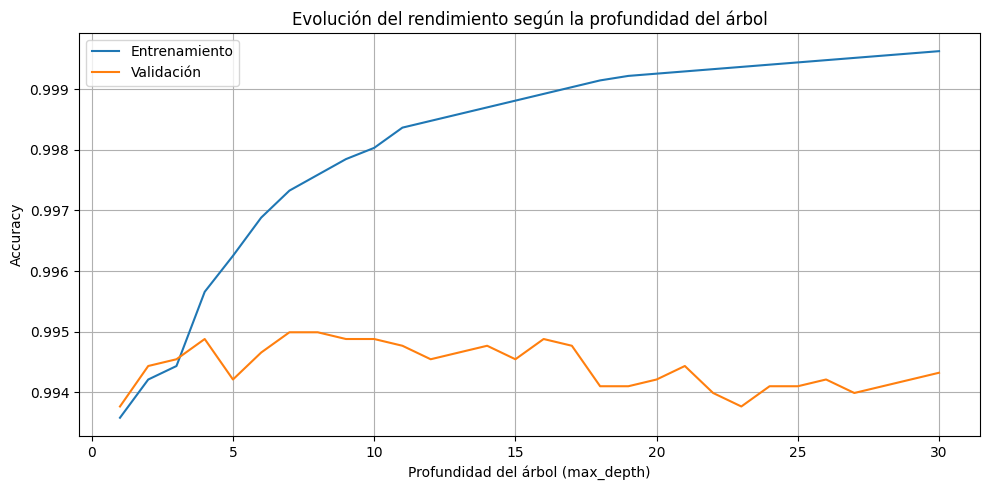

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

depths = list(range(1, 31))  # Probamos de 1 a 30
train_scores = []
val_scores = []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=42)
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    val_scores.append(accuracy_score(y_val, y_val_pred))

#Obtenemos la profundidad que consiguió el mayor porcentaje de aciertos
best_depth = depths[val_scores.index(max(val_scores))]
best_score = max(val_scores)
print(f"Mejor profundidad: {best_depth}, Accuracy de validación: {best_score:.4f}")

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(depths, train_scores, label='Entrenamiento')
plt.plot(depths, val_scores, label='Validación')
plt.xlabel('Profundidad del árbol (max_depth)')
plt.ylabel('Accuracy')
plt.title('Evolución del rendimiento según la profundidad del árbol')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Podemos observar claramente que a partir de cierta profundidad (aproximadamente una profundidad de entre 7 y 10) se produce una brecha entre la accuracy del conjunto de entrenamiento (que tiende a 1, es decir, al 100% de acierto en el conjunto de entrenamiento) y entre el conjunto de validación, que va perdiendo accuracy, aunque se mantiene muy elevada en torno al 0.994 que es muy buen valor.
Esto podría reflejar que a partir de profundidad 7-10 se produce un sobreentrenamiento utilizando árboles de decisión, por lo que nos quedamos con el valor del hiperparámetro a 10.

# **KNN o K vecinos más cercanos**

Procedemos ahora a realizar un entrenamiento con un segundo modelo, en este caso vamos a utilizar KNN o K vecinos más cercanos y veremos la diferencia con respecto a árboles de decisión.
Para evaluar el rendimiento del entrenamiento vamos a utilizar, al igual que en la práctica anterior, el error cuadrático medio MCE.
Además el hiperparámetro que vamos a utilizar es el k, y vamos a utilizar como siempre un diagrama de codo para decidir cual es el valor de k más apropiado para el entrenamiento.

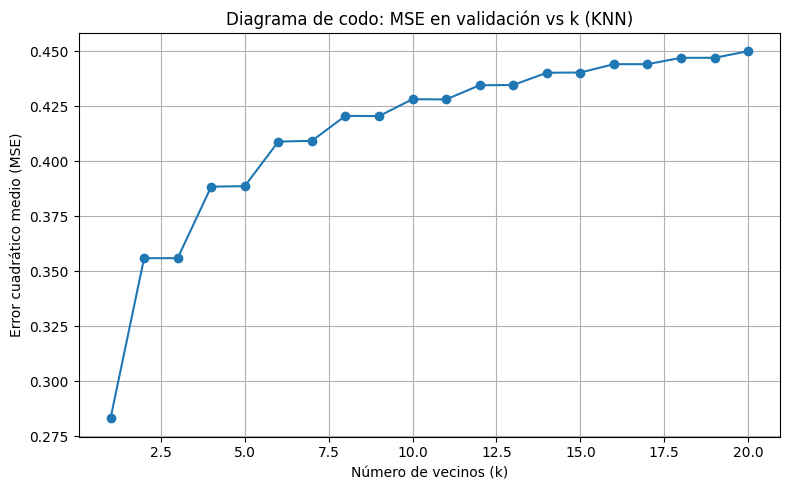

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Rango de k a probar
k_values = list(range(1, 21))
mse_scores = []

# Codificamos las etiquetas: fake = 1, true = 0
y_val_bin = (y_val == 'fake').astype(int)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    y_pred_bin = (y_val_pred == 'fake').astype(int)
    mse = mean_squared_error(y_val_bin, y_pred_bin)
    mse_scores.append(mse)

# Graficar el diagrama de codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, mse_scores, marker='o')
plt.title("Diagrama de codo: MSE en validación vs k (KNN)")
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Error cuadrático medio (MSE)")
plt.grid(True)
plt.tight_layout()
plt.show()


Vemos que hemos utilizado valores de k desde 1 hasta 21. Además, utilizando el diagrama de codo que hemos graficado, podemos observar que el valor de k más indicado es probablemente el valor 7, pues a partir del mismo el error cuadrático medio no experimenta cambios importantes.

# **Naive-Bayes**

Por último, procedemos a utilizar el modelo de entrenamiento de Naive Bayes, que recordemos es un clasificador probabilístico muy sencillo y muy poderoso en este contexto.


Este clasificador asume que todas las variables son independientes entre sí, es decir, la ocurrencia de una palabra en un texto es independiente del resto de palabras y pese a esta gran simplificación el clasificador suele dar buenos resultados.
Este aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, el clasificador estima la probabilidad de que pertenezca a cada una de las clases y elige la más alta.

Además, el clasificador Naive Bayes tiene otra ventaja, y es que es mucho más rápido de entrenar que otros modelos. De hecho, hemos tardado bastante más en entrenar el árbol de decisión y el knn que el clasificador Naive Bayes.


Existen 3 tipos de clasificadores Naive Bayes:
 - **Clasificador Multinomial:** funciona cuando las variables son enteras
aunque admite números decimales (como TF/IDF) y no admite números negativos

-  **Clasificador Gaussiano:** utilizado cuando la variable que interesa es continua y admite tanto valores positivos como negativos

- **Clasificador Bernuilli:** empleado cuando es la ausencia de determinadas palabras la que importa. Suele ser bueno para clasificar textos cortos como SPAM.

En nuestro caso vamos a utilizar Naive Bayes Multinomial como modelo de referencia, ya que es el más adecuado para tareas de clasificación de texto donde se utilizan representaciones tipo bolsa de palabras o TF-IDF.


Aunque este modelo fue diseñado originalmente para trabajar con conteos enteros, su uso con TF-IDF está ampliamente extendido y ha demostrado funcionar de forma robusta en problemas similares.

Antes de analizar el rendimiento final del clasificador, vamos a estudiar cual es el mejor valor para el hiperparámetro alpha (suavizado de Laplace) , que recordemos que controla cuánto suavizamos las probabilidades para evitar problemas cuando una palabra nunca ha aparecido en una clase durante el entrenamiento.
Para ello, vamos a hacer que dicho parámetro varíe entre 0.001 y 1.0 y vamos a ver la precisión del clasificador.



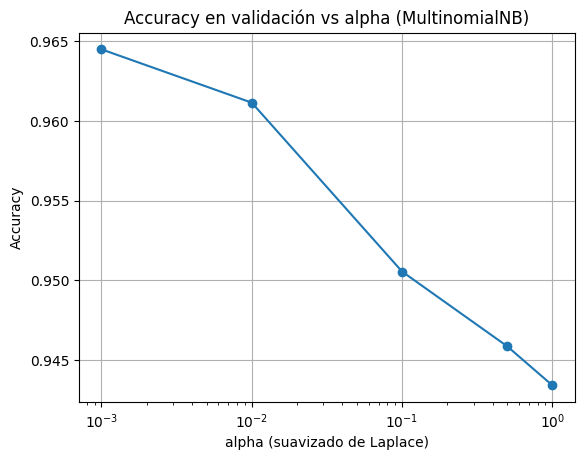

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0]
accuracies = []

for alpha in alpha_values:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Gráfica
import matplotlib.pyplot as plt

plt.plot(alpha_values, accuracies, marker='o')
plt.xscale('log')
plt.title("Accuracy en validación vs alpha (MultinomialNB)")
plt.xlabel("alpha (suavizado de Laplace)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


Vemos claramaente que el valor 0.001 del suavizado de Lapalace es el mejor para el entrenamiento, por lo que procederemos a utilizar ese valor para el hiperparámetro.

Además, para evaluar el rendimiento del clasificador de forma más detallada, se ha analizado la matriz de confusión, junto con las métricas de precisión (precision) y exhaustividad (recall) para cada una de las dos clases (fake y true) en las que se desea clasificar el conjunto de textos.

Estas métricas permiten no solo medir el número total de aciertos, sino también identificar qué tipo de errores comete el modelo, y si tiende a favorecer una clase frente a la otra.



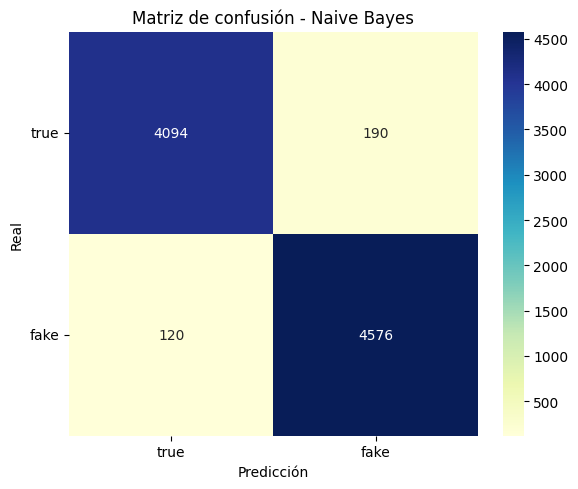

== MÉTRICAS DE CLASIFICACIÓN ==
              precision    recall  f1-score   support

        true       0.96      0.97      0.97      4696
        fake       0.97      0.96      0.96      4284

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980

Accuracy global: 0.9655


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Entrenar el modelo
nb = MultinomialNB(alpha=0.001)
nb.fit(X_train, y_train)

# Predicciones sobre el conjunto de test
y_test_pred = nb.predict(X_test)

# Matriz de confusión
labels = ['true', 'fake']  # Asegúrate de que coincide con tus clases
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Mostrar heatmap de la matriz de confusión
plt.figure(figsize=(6, 5))
sn.heatmap(conf_matrix_df, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Matriz de confusión - Naive Bayes")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Mostrar métricas detalladas
print("== MÉTRICAS DE CLASIFICACIÓN ==")
print(classification_report(y_test, y_test_pred, target_names=labels))

# (Opcional) Mostrar accuracy global
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy global: {accuracy:.4f}")


Observamos que hemos utilizado el conjunto X_test para medir la precisión global del clasificador.
Además, para ese suavizado de Laplace, por lo estudiado anteriormente, tenemos una precisión y un recall significativamente altos, por lo que podemos decir que nuestro clasificador funciona correctamente.

Así podemos ver que:

1.   El modelo clasifica correctamente el 96.55% de las noticias del conjunto de test. Excelente resultado, especialmente en un problema de PLN.

2.   De todas las veces que predice fake acierta el 97% y para las que predice true un 96%.

3.   De todas las noticias realmente fake detecta correctamente el 96% y para las true un 97%.

4.   Como F1-score (fake y true ≈ 0.96–0.97): tenemos un excelente equilibrio entre precisión y recall. El modelo es muy robusto.

5.   Como macro avg ≈ 0.97 tenemos media simple entre clases, por lo que no hay sesgo hacia una clase.


# 4) Construye redes neuronales con Keras con distintas maneras de usar word embeddings

Justifica tus decisiones y explica los resultados obtenidos.

Procedemos ahora a construir distintos modelos de redes neuronales utilizando word embeddings.
Recordemos que los word embeddings son representaciones vectoriales de las palabras en un espacio continuo de varias dimensiones, donde la distancia semántica entre palabras se refleja en la geometría del espacio vectorial.

En otras palabras, palabras que tienden a aparecer en contextos similares estarán representadas por vectores cercanos.
Esta representación captura de forma más rica las relaciones semánticas que una simple codificación one-hot, y permite que los modelos aprendan mejor el significado de las palabras en función de sus usos.

Existen diferentes formas de obtener word embeddings:

- Entrenándolos desde cero junto con el modelo (con la capa Embedding de Keras)

- Utilizando embeddings preentrenados (como GloVe o Word2Vec) y dentro de esta opción:

    - Congelando (no entrenamos) los embeddings durante el entrenamiento
    - Ajustando (fine-tuning) esos embeddings durante el entrenamiento



# **Entrenando los embeddings desde cero**






Comenzamos construyendo los word-embeddings entrenándolos desde cero con el
modelo, haciendo uso de la capa Embedding de Keras.
La forma más sencilla y directa de trabajar con word embeddings es entrenarlos desde cero como parte de nuestra red neuronal. Para ello, Keras ofrece la capa Embedding, que actúa como una tabla de búsqueda de vectores, donde cada palabra del vocabulario está asociada a un vector de tamaño fijo (las dimensiones del embedding).

Inicialmente, los vectores de cada palabra se inicializan aleatoriamente y luego se actualizan durante el entrenamiento mediante backpropagation, al igual que los pesos de cualquier otra capa. De este modo, la red aprende qué relaciones semánticas entre palabras son útiles para la tarea de clasificación que queremos resolver.

Esta técnica tiene la ventaja de no depender de datos externos, y de adaptarse completamente al dominio de nuestro corpus. Sin embargo, requiere más datos y entrenamiento para que los vectores converjan a representaciones útiles.

Primero, se procede a tokenizar cada uno de los textos del corpus, convirtiendo las palabras en índices numéricos según su frecuencia.

Además, se establecen varios hiperparámetros clave:

- max_words = 10.000: número máximo de palabras del vocabulario (solo se conservan las más frecuentes).

- embedding_dim = 100: dimensión de los vectores que representarán cada palabra.

- max_comment_length = 100: longitud máxima (en palabras) de cada texto; los textos más largos se truncarán, y los más cortos se rellenarán (padding).

Estas restricciones se aplican para controlar la complejidad del modelo y reducir el uso de memoria.
Si no se limitaran estos valores, se generarían matrices de word embeddings demasiado grandes, con millones de parámetros, lo que haría inviable su entrenamiento en condiciones normales.



In [ ]:
pip install keras

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Hiperparámetros
max_words = 10000
embedding_dim = 100
max_comment_length = 100

# Tokenizar los textos
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# Padding
x_data = pad_sequences(sequences, maxlen=max_comment_length)

# Etiquetas
y_data = df['label'].apply(lambda x: 1 if x == 'fake' else 0).values


In [ ]:
from sklearn.model_selection import train_test_split

# Paso 1: 60% train, 40% restante
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=0.4, stratify=y_data, random_state=RANDOM_STATE)

# Paso 2: de ese 40%, sacar 20% val y 20% test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)

In [ ]:
# MODELO 1. SIN EMBEDDINGS PRE-ENTRENADOS

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

model1 = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs


model1.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
# After the Embedding layer, our activations have shape `(max_words, max_comment_length, embedding_dim)`.

# We flatten the 3D tensor of embeddings into a 2D tensor of shape `(max_words, max_comment_length * embedding_dim)`

model1.add(Flatten())

# We add the classifier on top
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

history = model1.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

score1 = model1.evaluate(x_test, y_test)

print("Accuracy: %.2f%%" % (score1[1]*100))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8934 - loss: 0.2968 - val_accuracy: 0.9876 - val_loss: 0.0403
Epoch 2/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9963 - loss: 0.0181 - val_accuracy: 0.9888 - val_loss: 0.0324
Epoch 3/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9997 - loss: 0.0039 - val_accuracy: 0.9894 - val_loss: 0.0309
Epoch 4/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9899 - val_loss: 0.0322
Epoch 5/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 1.0000 - loss: 5.5038e-04 - val_accuracy: 0.9898 - val_loss: 0.0338
Epoch 6/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 1.0000 - loss: 2.7358e-04 - val_accuracy: 0.9899 - val_loss: 0.0349
Epoch 7/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 1.5407e-04 - val_accuracy: 0.9894 - val_loss: 0.0363
Epoch 8/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 1.0000 - loss: 8.9429e

Vemos como se ha entrenado una red neuronal con una capa Embedding inicializada aleatoriamente, es decir, aprendiendo los word embeddings desde cero.

Tras 20 épocas de entrenamiento, el modelo alcanzó una precisión del 99.01% en el conjunto de test, lo cual indica que las representaciones aprendidas son muy efectivas para esta tarea.
Sin embargo, se observa que la precisión en el conjunto de entrenamiento alcanza el 100% desde las primeras épocas, mientras que en validación se estabiliza cerca del 98.8%.
Esto sugiere que el modelo está comenzando a sobreajustar, por lo que podría beneficiarse de técnicas como early stopping o regularización para mejorar su capacidad de generalización.



# **Word-Embeddings pre-entrenados (congelados)**



Procedemos ahora a construir word-embeddings de distinta manera, pues esta vez en vez de entrenar el modelo desde cero vamos a utilizar word-embeddings pre-entrenados, es decir, vectores ya aprendidos a partir de un corpus masivo, en este caso GloVe (Global Vectors for Word Representation), entrenado por Stanford en Wikipedia y Gigaword.

Cada palabra se representa como un vector en un espacio semántico de alta dimensión, donde la distancia entre vectores refleja similitud semántica.
Por ejemplo, vec("king") - vec("man") + vec("woman") ≈ vec("queen").

En esta versión del modelo, los embeddings se utilizan tal y como fueron aprendidos, es decir, sin permitir que la red neuronal los modifique. Esto se consigue congelando la capa de embeddings (trainable=False).

Esta estrategia suele ser útil cuando:

- El corpus de entrenamiento es pequeño

- Las representaciones semánticas generales ya son suficientemente buenas

- Se busca entrenar más rápido y con menos riesgo de sobreajuste



Para ello, debemos en primer lugar descargar el word-embedding de Glove de su página `https://nlp.stanford.edu/projects/glove/`. Nosotros como en notebook de ejemplo vamos a descargar la versión de 2014 de la Wikipedia + Gigaword 5.

Así, vamos a cargar el archivo glove.6B.50d.txt, el cual contiene embeddings preentrenados de 50 dimensiones generados por el proyecto GloVe (Stanford NLP).
Cada línea del archivo representa una palabra y su vector asociado. Estos vectores se almacenan en un diccionario embeddings_index, que posteriormente se utilizará para construir la matriz de embeddings del modelo.



In [ ]:
import os
import numpy as np

embeddings_index = {}
f = open(os.path.join(filepath, 'glove.6B.50d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


A partir del diccionario embeddings_index generado previamente con los vectores de GloVe, se construye ahora una matriz de embeddings que será utilizada como pesos iniciales de la capa Embedding del modelo.

Esta matriz tiene forma (max_words, embedding_dim), donde cada fila i contiene el vector de dimensión embedding_dim correspondiente a la palabra con índice i en el Tokenizer.

El índice 0 se reserva habitualmente como token especial de relleno (padding) y no se asocia a ninguna palabra real, por lo que su fila se deja en ceros.

En caso de que alguna palabra del vocabulario no exista en el archivo de embeddings de GloVe (por ejemplo, nombres propios raros, errores tipográficos o jergas), se deja su vector correspondiente también como un vector de ceros.

In [ ]:
embedding_dim = 50
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

A continuación vamos a  utilizar una red neuronal con nuestros embeddings preentrenados de GloVe, donde recordemos que cada palabra se representa mediante un vector de 50 dimensiones previamente aprendido a partir de un gran corpus.

La capa Embedding se inicializa con esta matriz preentrenada y congelada (trainable=False), lo que significa que sus pesos no se modificarán durante el entrenamiento. Esta técnica permite aprovechar el conocimiento semántico ya adquirido en el embedding GloVe, evitando que el modelo lo sobreentrene en un corpus específico o pequeño.

La arquitectura es sencilla y se compone de:

- Capa Embedding con pesos preentrenados

- Capa Flatten para aplanar la secuencia

- Capa Dense final con activación sigmoide para clasificación binaria

Vamos a compilar y entrenar el modelo sobre los datos ya tokenizados y con padding aplicados, utilizando el mismo vocabulario que se usó para construir la embedding_matrix.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
import numpy as np

# Mostramos información clave para depuración
print(f"max_words: {max_words}, embedding_dim: {embedding_dim}, max_comment_length: {max_comment_length}")
print(f"embedding_matrix shape: {embedding_matrix.shape}")

# MODELO 2 — Embeddings preentrenados (GloVe), CONGELADOS

# Creamos el modelo secuencial
model2 = Sequential()

# Añadimos una capa Embedding inicializada con los vectores de GloVe y congelada
model2.add(Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],     # Se cargan los pesos preentrenados
    input_length=max_comment_length,
    trainable=False                 # ← Esto congela la capa: no se entrena
))

# Aplanamos la salida para conectarla con la capa densa final
model2.add(Flatten())

# Capa de salida binaria (clasificación fake vs true)
model2.add(Dense(1, activation='sigmoid'))

# Compilamos el modelo
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostramos la arquitectura
model2.summary()

max_words: 10000, embedding_dim: 50, max_comment_length: 100
embedding_matrix shape: (10000, 50)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 500,000 (1.91 MB)

In [ ]:
# Ensure shape matches before setting weights
if embedding_matrix.shape == (max_words, embedding_dim):
    model2.layers[0].set_weights([embedding_matrix])
    model2.layers[0].trainable = False
else:
    print("Error: embedding_matrix has incorrect shape.")

Procedemos así a entrenar el modelo, para lo cual, al igual que hicimos con el modelo sin pre-entrenado, vamos a utilizar 20 epochs o episodios de entrenamiento, y ver los resultados en comparación con el entrenamiento anterior.



In [ ]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

score2 = model2.evaluate(x_test, y_test)

Epoch 1/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8684 - loss: 0.3106 - val_accuracy: 0.9298 - val_loss: 0.1881
Epoch 2/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9454 - loss: 0.1594 - val_accuracy: 0.9318 - val_loss: 0.1811
Epoch 3/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9553 - loss: 0.1320 - val_accuracy: 0.9354 - val_loss: 0.1772
Epoch 4/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9629 - loss: 0.1113 - val_accuracy: 0.9347 - val_loss: 0.1825
Epoch 5/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9630 - loss: 0.1049 - val_accuracy: 0.9370 - val_loss: 0.1832
Epoch 6/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9718 - loss: 0.0932 - val_accuracy: 0.9293 - val_loss: 0.2002
Epoch 7/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9703 - loss: 0.0879 - val_accuracy: 0.9273 - val_loss: 0.2112
Epoch 8/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9751 - loss: 0.0794 - val_accuracy: 0.

El modelo basado en embeddings preentrenados GloVe congelados ha alcanzado una precisión del 92.76% sobre el conjunto de test.
Aunque el entrenamiento alcanzó un rendimiento casi perfecto (99.4%), la precisión en validación se estabilizó en torno al 92.8%, mientras que la función de pérdida de validación (val_loss) aumentó de forma progresiva, indicando un posible caso de overfitting.

Esto es coherente con el hecho de que los embeddings preentrenados no han sido ajustados durante el entrenamiento (trainable=False).
Si bien esta estrategia protege frente a sobreajuste del embedding, también limita la capacidad de la red para adaptar esas representaciones a los matices específicos del corpus actual.

En conjunto, este enfoque ofrece un rendimiento alto y estable, especialmente adecuado cuando el tamaño del corpus es limitado y se desea aprovechar conocimiento lingüístico general.

# **Word-Embeddings pre-entrenados (sin congelar)**


Por último, vamos a utilizar un último modelo basado en Keras, con el modelo pre-entrenado, pero esta vez sin congelar.

Así, este modelo utiliza nuevamente los vectores preentrenados de GloVe para inicializar la capa de embeddings, pero con una diferencia clave respecto al modelo anterior:
esta vez, los pesos de la capa de embeddings no se congelan, lo que permite que el modelo los ajuste durante el entrenamiento en función del corpus específico del problema.

Esta estrategia permite que el modelo parta de una representación semántica general y bien estructurada, pero tenga la capacidad de afinarla y adaptarla a las particularidades del dominio del texto (por ejemplo, política, economía, fake news, etc.).

Esto puede traducirse en una mejor generalización si el corpus es lo suficientemente representativo, aunque con el riesgo de sobreajustar si no se controla adecuadamente.

Al igual que en los modelos anteriores, se mantiene una arquitectura simple:

- Capa Embedding inicializada con los vectores GloVe, pero con trainable=True

- Capa Flatten para reducir la dimensionalidad

- Capa Dense con activación sigmoide para clasificación binaria

Así, nos aprovechamos del modelo pre entrenado anterior, para entrenar a nuestro tercer modelo, esta vez sin congelar:

In [ ]:
# MODELO3. EMBEDDINGS PREENTRENADOS SIN CONGELAR

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=max_comment_length))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.build(input_shape=(None, max_comment_length)) #####
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = True

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model3.fit(x_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

score3 = model3.evaluate(x_test, y_test)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8889 - loss: 0.2556 - val_accuracy: 0.9708 - val_loss: 0.0784
Epoch 2/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9870 - loss: 0.0451 - val_accuracy: 0.9792 - val_loss: 0.0582
Epoch 3/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9975 - loss: 0.0148 - val_accuracy: 0.9811 - val_loss: 0.0516
Epoch 4/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9998 - loss: 0.0047 - val_accuracy: 0.9827 - val_loss: 0.0499
Epoch 5/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9829 - val_loss: 0.0501
Epoch 6/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 1.0000 - loss: 9.9977e-04 - val_accuracy: 0.9834 - val_loss: 0.0507
Epoch 7/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 1.0000 - loss: 5.7434e-04 - val_accuracy: 0.9839 - val_loss: 0.0519
Epoch 8/20
842/842 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 1.0000 - loss: 3.4692e-04 - va

Tras 20 épocas de entrenamiento, el modelo ha alcanzado una precisión del 98.96% en el conjunto de test, superando tanto al modelo con embeddings entrenados desde cero como al modelo con embeddings preentrenados congelados.
La precisión en validación se ha mantenido estable a lo largo del entrenamiento (~98.6%), mientras que la función de pérdida ha crecido ligeramente, pero sin señales de sobreajuste significativas.

Estos resultados indican que permitir que el modelo ajuste los embeddings contribuye positivamente al rendimiento, especialmente si el corpus tiene suficiente tamaño como para evitar el sobreajuste.



En conclusión, tras comparar los tres enfoques, el modelo que ofrece el mejor equilibrio entre rendimiento y generalización es el de embeddings preentrenados GloVe ajustables (no congelados).
Este modelo alcanza una precisión del 98.96% en test, superando al resto y demostrando que combinar conocimiento semántico previo con capacidad de adaptación al corpus específico es la estrategia más efectiva para esta tarea.



# 5) Aplica los modelos construidos a los datos de test y compáralos.

Calcula las métricas de recall, precisión y f1.
Discute cual es el mejor modelo y cual es peor y porqué.

Creemos una función auxiliar que dado el modelo y los datos de test nos calcule las métricas

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluar_modelo(modelo, x_test, y_test, nombre="Modelo"):
    y_pred_probs = modelo.predict(x_test)
    y_pred = (y_pred_probs > 0.5).astype("int32")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Resultados para {nombre}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("-" * 40)

    return {
        "nombre": nombre,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1
    }

# Evaluamos los tres modelos
resultados1 = evaluar_modelo(model1, x_test, y_test, nombre="Modelo 1")
resultados2 = evaluar_modelo(model2, x_test, y_test, nombre="Modelo 2")
resultados3 = evaluar_modelo(model3, x_test, y_test, nombre="Modelo 3")

df_resultados = pd.DataFrame([resultados1, resultados2, resultados3])
df_resultados

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Resultados para Modelo 1
Accuracy:  0.9900
Precisión: 0.9910
Recall:    0.9898
F1-score:  0.9904
----------------------------------------
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Resultados para Modelo 2
Accuracy:  0.9255
Precisión: 0.9065
Recall:    0.9561
F1-score:  0.9307
----------------------------------------
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
📊 Resultados para Modelo 3
Accuracy:  0.9882
Precisión: 0.9887
Recall:    0.9887
F1-score:  0.9887
----------------------------------------


,nombre,accuracy,precision,recall,f1_score
0,Modelo 1,0.989978,0.991047,0.989781,0.990413
1,Modelo 2,0.925501,0.906540,0.956142,0.930681
2,Modelo 3,0.988196,0.988716,0.988716,0.988716


En un primer vistazo, vemos que los 3 modelos son bastante competentes siendo el modelo 2 (entrenado con embeddings pre-entrenados y congelándolos) ligeramente inferior a los otros dos.

Esto es probablemente a que al contrario que con el modelo 1 (entrenando los embeddings desde cero) y con el modelo 3 (adaptando los embeddings pre-entrenados), en el modelo 2 no permitimos que los embeddings se adapten a nuestro corpus.

Quédandonos con los modelos restantes, el modelo 1 es muy ligeramente superior en la mayoría de métricas, pero al ser esta mejora apenas significativa y estar ligada a embeddings específicos entrenados sobre este corpus decidiríamos quedarnos con el modelo 3.

Esta decisión se basa en que al tomar embeddings pre-entrenados con otros corpus la escalabilidad de este modelo debería de ser significativamente mayor a la del modelo 1 por si en algún momento quisieramos aplicarlo a otros corpus de noticias.